In [7]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-749b3eb0-7b01-dec5-578c-4fa109ee96ab)


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Scrap Images**

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin



In [ ]:
import selenium
from selenium import webdriver
import time
import os
import requests
import io 
from PIL import Image
import hashlib

In [ ]:
from selenium import webdriver
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.get("https://www.google.co.id")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


In [ ]:
def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.co.id/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

In [ ]:
def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

In [ ]:
def search_and_download(search_term:str,wd,number_images=5,target_path='/content/drive/MyDrive/foodviz/images'):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5)
        
    for elem in res:
        persist_image(target_folder,elem)

In [ ]:
# search_and_download('pempek',wd,40)

**Create model**

In [47]:
import tensorflow
import os
# model = tf.keras.models.load_model("/content/drive/MyDrive/sample_foodviz/EfficientNetB1.hdf5")

In [48]:
from tensorflow import keras
import joblib
import operator

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import decode_predictions

from tensorflow.keras.applications import MobileNetV2 

In [49]:
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

# model = tensorflow.keras.applications.mobilenet.MobileNet(
model = MobileNetV2(
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
x = Dropout(rate=0.4)(model.output)
x = Dense(34)(x)
x = Softmax()(x)
model= Model(model.inputs, x)

for layer in model.layers[:-3]:
    layer.trainable = False

from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.applications import mobilenet as _mobilenet

datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

ensure_folder_exists('/content/drive/MyDrive/foodviz/training_10')
training = datagen.flow_from_directory( 
    '/content/drive/MyDrive/foodviz/images', 
    target_size=(224, 224),
    save_to_dir='/content/drive/MyDrive/foodviz/training_10',
    subset='training'
) 

ensure_folder_exists('/content/drive/MyDrive/foodviz/validation_10')
validation = datagen.flow_from_directory( 
    '/content/drive/MyDrive/foodviz/images',
    target_size=(224, 224),
    save_to_dir='/content/drive/MyDrive/foodviz/validation_10',
    subset='validation'
) 

# from tensorflow.keras.tqdm import TQDMNotebookCallback

batch_size = 32

history = model.fit_generator(
    generator=training,
    # steps_per_epoch=training.samples // batch_size,
    epochs=10,
    # callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Found 1331 images belonging to 34 classes.
Found 321 images belonging to 34 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
42/42 [==============================] - 86s 2s/step - loss: 3.0919 - accuracy: 0.2044 - val_loss: 1.8197 - val_accuracy: 0.5938
Epoch 2/10
42/42 [==============================] - 81s 2s/step - loss: 1.6025 - accuracy: 0.5545 - val_loss: 1.1768 - val_accuracy: 0.7437
Epoch 3/10
42/42 [==============================] - 79s 2s/step - loss: 1.0541 - accuracy: 0.7077 - val_loss: 0.9455 - val_accuracy: 0.8000
Epoch 4/10
42/42 [==============================] - 81s 2s/step - loss: 0.8631 - accuracy: 0.7701 - val_loss: 0.7721 - val_accuracy: 0.8125
Epoch 5/10
42/42 [==============================] - 81s 2s/step - loss: 0.6908 - accuracy: 0.8167 - val_loss: 0.7041 - val_accuracy: 0.8313
Epoch 6/10
42/42 [==============================] - 83s 2s/step - loss: 0.5620 - accuracy: 0.8520 - val_loss: 0.6488 - val_accuracy: 0.8281
Epoch 7/10
42/42 [==============================] - 83s 2s/step - loss: 0.4957 - accuracy: 0.8813 - val_loss: 0.6099 - val_accuracy: 0.8500
Epoch 8/10
42/42 [==

In [ ]:
model = MobileNetV2(
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
x = Dropout(rate=0.4)(model.output)
x = Dense(34)(x)
x = Softmax()(x)
model= Model(model.inputs, x)

for layer in model.layers[:-3]:
    layer.trainable = False

from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.applications import mobilenet as _mobilenet
batch_size = 32

history = model.fit_generator(
    generator=training,
    # steps_per_epoch=training.samples // batch_size,
    epochs=20,
    # callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

In [ ]:
model_viz = tensorflow.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=55
)
model_viz


In [54]:
model.evaluate(training)

42/42 [==============================] - 68s 2s/step - loss: 0.2187 - accuracy: 0.9669


[0.21865372359752655, 0.9669421315193176]

In [53]:
model.evaluate(validation)

11/11 [==============================] - 17s 2s/step - loss: 0.5274 - accuracy: 0.8629


[0.5274448394775391, 0.8629283308982849]

In [56]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

In [57]:
import matplotlib.pyplot as plt

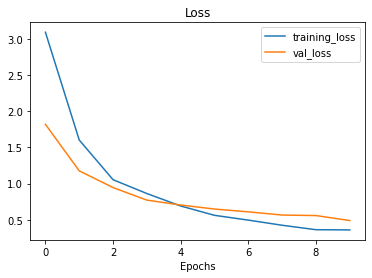

In [59]:
# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

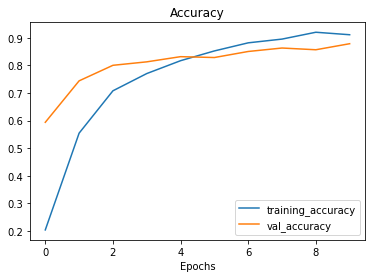

In [60]:
# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [51]:
import joblib

# joblib.dump(datagen, "/content/drive/MyDrive/foodviz/datagen.joblib")
model.save("/content/drive/MyDrive/foodviz/fcvmodel.h5")

saved_model_dir = '' #means current directory
tf.saved_model.save(model, saved_model_dir) #saves to the current directory

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: assets


INFO:tensorflow:Assets written to: assets


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/foodviz/fcvmodel.h5')
# datagen = joblib.load('datagen.joblib')

def getPrediction(img):
    image = img
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    yhat = model.predict(image)
    label = yhat[0]
    a,b,c,d = np.round(label[0]*100,2),np.round(label[1]*100,2),np.round(label[2]*100,2),np.round(label[3]*100,2)
    top = dict(zip(['bakso','pempek','sate','soto'], [a,b,c,d]))
    top3 = dict(sorted(top.items(), key=operator.itemgetter(1), reverse=True)[:3])
    return top3

In [ ]:
import sys
from PIL import Image
import numpy as np
sys.modules['Image'] = Image 
img = Image.open('/content/drive/MyDrive/images/bakso/c83fdadd1a.jpg')
newsize = (224, 224)
img = img.resize(newsize)

test = getPrediction(img)
print(test)

{'bakso': 54.41, 'pempek': 8.21, 'sate': 2.57, 'soto': 34.8}


In [ ]:
test = getPrediction(img)
print(test)

{'bakso': 55.79, 'gado_gado': 9.41, 'sate': 11.32, 'soto': 23.48}


In [ ]:
pip freeze > requirements.txt

In [52]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert() #converts our model into a .tflite model which flutter uses for ondevice machine learning

with open('/content/drive/MyDrive/foodviz/model10.tflite', 'wb') as f: #to write the converted model into a file, written as binary so add 'wb' instead of 'w'
  f.write(tflite_model)